В социальной сети twitter (являющейся запрещенной на территории РФ соц. сетью) имеется огромное число твитов со словами, которые можно воспринимать двусмысленно. Например слово "ablaze" - в огне может использоваться как для описания красивого заката, так и для описания пожара.

Задача: научится различать твиты о стихийных бедствиях от твитов, касающихся повседневной жизни.

Датасет взят отсюда: https://www.kaggle.com/competitions/nlp-getting-started

===================================================================================================================

Инструменты, которыми мы пользуемся: библиотека pandas для загрузки csv файлов, библиотека nltk для избавления от stopwords в твитах, sklearn обработки датасета и подсчета метрик и torch для самой нейронной сети.

===================================================================================================================

1. Загружаем данные и анализируем их, убираем признаки, слабо влияющие на точность
2. Занимаемся препроцессингом текста при помощи nltk и re (regular expressions)
3. Делаем свой токенайзер
4. Разбиваем датасет на тренировочный и валидационный и преобразуем в формат pytorch
5. Объявляем нейронную сеть и тренируем ее
6. Делаем предсказание для тестовых данных и засылаем на Kaggle

# 1

In [1]:
!gdown "1fuinpl19t1Ra4lC02EwmTVlvIqbNuSoZ"
!gdown "1zIVLmMsCfgPrYQKjUfk-gMzb7uNQrDg4"
!gdown "1g4nAy4ihV1xr9wF5ZbIhQ2iirB6FJf8b"

Downloading...
From: https://drive.google.com/uc?id=1fuinpl19t1Ra4lC02EwmTVlvIqbNuSoZ
To: /content/train.csv
100% 988k/988k [00:00<00:00, 83.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zIVLmMsCfgPrYQKjUfk-gMzb7uNQrDg4
To: /content/test.csv
100% 421k/421k [00:00<00:00, 142MB/s]
Downloading...
From: https://drive.google.com/uc?id=1g4nAy4ihV1xr9wF5ZbIhQ2iirB6FJf8b
To: /content/sample_submission.csv
100% 22.7k/22.7k [00:00<00:00, 57.0MB/s]


Смотрим первые 5 элементы в датасете (трейновом)

In [2]:
import pandas as pd

train = pd.read_csv("train.csv")
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
train.shape

(7613, 5)

In [4]:
train.keyword.isnull().sum()

61

In [5]:
train.location.isnull().sum()

2533

Посчитали сколько реальных проишествий и сколько "фейковых"

In [6]:
sum(train["target"] == 0), sum(train["target"] == 1)

(4342, 3271)

Удалим незаполненные колонки, поэксперементировав я понял, что используя их особо точность не увеличивается

In [7]:
train.drop(columns=["keyword", "location"], inplace=True)

In [8]:
train.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


# 2
Препроцессинг текста

In [9]:
import nltk

nltk.download('stopwords')

stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [10]:
import re

def preproc(data):
    text = re.sub(r'https?://\S+|www\.\S+|http?://\S+', ' ', data)
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.lower().strip()
    text = [i for i in text.split() if i not in stopwords]

    return text

train.text[6], preproc(train.text[6])

('#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas',
 ['flood',
  'disaster',
  'heavy',
  'rain',
  'causes',
  'flash',
  'flooding',
  'streets',
  'manitou',
  'colorado',
  'springs',
  'areas'])

Сам препроцессинг

In [11]:
train.text = train.text.map(preproc)
train.head()

,id,text,target
0,1,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,"[residents, asked, shelter, place, notified, o...",1
3,6,"[people, receive, wildfires, evacuation, order...",1
4,7,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


In [12]:
train.text.map(len).mean()

9.144621042952844

# 3

Делаем собственный токенайзер

In [13]:
class Tokenizer:
    def __init__(self, vocabulary):
        self.w2i = {"<UNK>": 1, "<PAD>": 0} #UNK если встретили новое слово, PAD если нужно дополнить до какого то размера
        tmp = 2
        for i in vocabulary:
            for j in i:
                if j not in self.w2i:
                    self.w2i[j] = tmp
                    tmp += 1

    def __call__(self, text):
        return [self.w2i[i] if i in self.w2i else 1 for i in text]

    def __len__(self):
        return len(self.w2i)

tokenizer = Tokenizer(train.text.tolist())

train.text[1501], tokenizer(train.text[1501])

(['catastrophic',
  'effects',
  'hiroshima',
  'nagasaki',
  'atomic',
  'bombings',
  'still',
  'felt',
  'today'],
 [4839, 3425, 3926, 4103, 1934, 5184, 518, 5185, 502])

In [14]:
len(tokenizer)

16069

# 4

Пишем датасет pytocrha

In [15]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(train.text.tolist(), train.target.tolist(), test_size=0.2, random_state=3407)

len(x_train), len(x_val)

(6090, 1523)

In [16]:
import torch

torch.manual_seed(3407)
torch.cuda.manual_seed_all(3407)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [17]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, text, target):
        self.text = text
        self.target = target

    def __len__(self):
        return len(self.target)

    def __getitem__(self, index):
        return torch.LongTensor(tokenizer(self.text[index])), torch.LongTensor([self.target[index]])

trainds = MyDataset(x_train, y_train)
valds = MyDataset(x_val, y_val)

trainds[0]

(tensor([1415,   73, 7784, 2687,  862, 7712, 7785, 3551]), tensor([0]))

In [18]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch): #дополняет элементы бача до максимальной длины предложения PAD токенами
    texts, labels = zip(*batch)
    return pad_sequence(texts, batch_first=True, padding_value=0), torch.stack(labels)

traindl = DataLoader(trainds, batch_size=32, shuffle=True, collate_fn=collate_fn)
valdl = DataLoader(valds, batch_size=16, shuffle=False, collate_fn=collate_fn)

next(iter(traindl))

(tensor([[ 8427,  8428,  7619,  4501,  4328,    10,   383,   488,  8427,    22,
            352,   723,  8429,     0,     0],
         [ 1830, 14380,  2235,  1832,  1833,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0],
         [ 4141, 11498, 11499, 11500,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0],
         [ 3190, 11069,     5,  5232,  2417,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0],
         [  668,  1117,  1118,   829,  1119,  1117,     9,   465,  1104,  1120,
           1114,  1121,  1122,   723,  1123],
         [ 5457,  5431,  1492,  1794,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0],
         [ 9372,   288,  2332,  6886,  9352, 11370,  2403,  1793, 11371,     0,
              0,     0,     0,     0,     0],
         [  665,   322,    60,  3013,  3014,  1419,   145,   124,   764,  2927,
              0,     0,     0,     0, 

# 5

In [19]:
from torch import nn

class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=len(tokenizer.w2i), embedding_dim=256, padding_idx=0) #создаем эмбединг
        self.rnn = nn.GRU(input_size=256, hidden_size=256, batch_first=True) #создаем рнн
        self.linear = nn.Linear(in_features=256, out_features=128) #создаем линейный слой
        self.relu = nn.ReLU()
        self.classifier = nn.Linear(in_features=128, out_features=1) #создаем линейный слой, который преобразует в размерность 1

    def forward(self, x):
        x = self.embedding(x)
        x, h = self.rnn(x)
        x = self.linear(h)
        x = self.relu(x)
        x = self.classifier(x)
        return x

model = MyModel()
model(next(iter(traindl))[0])

tensor([[[ 1.9650e-03],
         [-3.1426e-04],
         [ 1.8343e-03],
         [ 4.2062e-04],
         [-3.0454e-03],
         [-1.3403e-05],
         [-2.7271e-03],
         [ 2.4171e-03],
         [ 3.8285e-04],
         [-4.9092e-04],
         [-1.4172e-03],
         [-1.9894e-03],
         [ 3.5205e-04],
         [ 5.0633e-04],
         [ 2.5745e-03],
         [ 1.4093e-03],
         [-4.0596e-04],
         [-2.3969e-04],
         [-3.0856e-04],
         [-3.5261e-04],
         [ 1.3801e-04],
         [-3.1233e-04],
         [-1.0846e-03],
         [-3.7538e-02],
         [-3.1046e-04],
         [-6.0179e-04],
         [-4.2457e-04],
         [ 3.3694e-03],
         [ 1.9770e-03],
         [-3.0412e-04],
         [-3.5150e-04],
         [ 1.0189e-03]]], grad_fn=<ViewBackward0>)

In [20]:
from sklearn.metrics import *
import numpy as np

def train_loop(model, criterion, optimizer, traindl):
    train_loss = 0
    for x, y in traindl:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        pred = pred.view(y.size())
#         print(pred.size(), y.size())
        y = y.type_as(pred)
        loss = criterion(pred, y)
        loss.backward() #обратное распространение ошибки
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(traindl)
    return train_loss

def val_loop(model, criterion, valdl):
    val_loss = 0
    val_acc = 0
    val_f1 = 0
    for x, y in valdl:
        with torch.no_grad():
            x, y = x.to(device), y.to(device)
            pred = model(x)
            pred = pred.view(y.size())
    #         print(pred.size(), y.size())
            y = y.type_as(pred)
            loss = criterion(pred, y)
            val_loss += loss.item()
            y = y.cpu().numpy() #нампай работает только с процессором
            pred = np.round(pred.cpu().sigmoid().numpy())
            val_acc += accuracy_score(y, pred)
            val_f1 += f1_score(y, pred)

    val_loss /= len(valdl)
    val_acc /= len(valdl)
    val_f1 /= len(valdl)

    return val_loss, val_acc, val_f1

In [21]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
criterion = nn.BCEWithLogitsLoss()
epochs = 10
for epoch in range(epochs):
    print(f'epoch = {epoch + 1}')
    model.train()
    trl = train_loop(model, criterion, optimizer, traindl)
    print(f"train loss = {trl}")
    model.eval()
    vl, va, vf1 = val_loop(model, criterion, valdl)
    print(f"val loss = {vl}, acc = {va}, f1 = {vf1}")
    print("=" * 30)

epoch = 1
train loss = 0.6328536952353273
val loss = 0.5596356090779105, acc = 0.7276475694444445, f1 = 0.6019097006115782
epoch = 2
train loss = 0.479743438319386
val loss = 0.517316214274615, acc = 0.7628038194444445, f1 = 0.6618413670343812
epoch = 3
train loss = 0.37650033324488796
val loss = 0.525036244187504, acc = 0.7651909722222222, f1 = 0.6862868795675823
epoch = 4
train loss = 0.2990416855946261
val loss = 0.5271023195236921, acc = 0.7829861111111112, f1 = 0.6912164332522891
epoch = 5
train loss = 0.23327223389014523
val loss = 0.5559816389965514, acc = 0.7725694444444445, f1 = 0.7058262761375141
epoch = 6
train loss = 0.17619934794127318
val loss = 0.6958320929358403, acc = 0.7671440972222222, f1 = 0.6959575901268716
epoch = 7
train loss = 0.14009798415180744
val loss = 0.7178171717872223, acc = 0.7638888888888888, f1 = 0.7000110820580007
epoch = 8
train loss = 0.11391281013264862
val loss = 0.8361577178972462, acc = 0.7502170138888888, f1 = 0.6921310780758341
epoch = 9
trai

# 6

Делаем предсказание для тестовых данных и засылаем на кагл

In [22]:
sample = pd.read_csv("sample_submission.csv")
sample

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [23]:
test = pd.read_csv("test.csv")

test.text = test.text.map(preproc)
testds = MyDataset(test.text.tolist(), test.id.tolist())
testdl = DataLoader(testds, batch_size=32, collate_fn=collate_fn)

result = {"id": [], "target": []}
model.eval()
for x, y in testdl:
    x = x.to(device)
    with torch.no_grad():
        pred = model(x)
        pred = pred.sigmoid()
#         print(pred.size(), y.size())
        for i in range(y.size()[0]):
            result["id"].append(y[i][0].item())
            result["target"].append(round(pred[0][i][0].item()))

print(result["id"][:15])
print(result["target"][:15])

[0, 2, 3, 9, 11, 12, 21, 22, 27, 29, 30, 35, 42, 43, 45]
[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [24]:
pd.DataFrame(result).to_csv("submit.csv", index=False)

# Результат

Score на Kaggle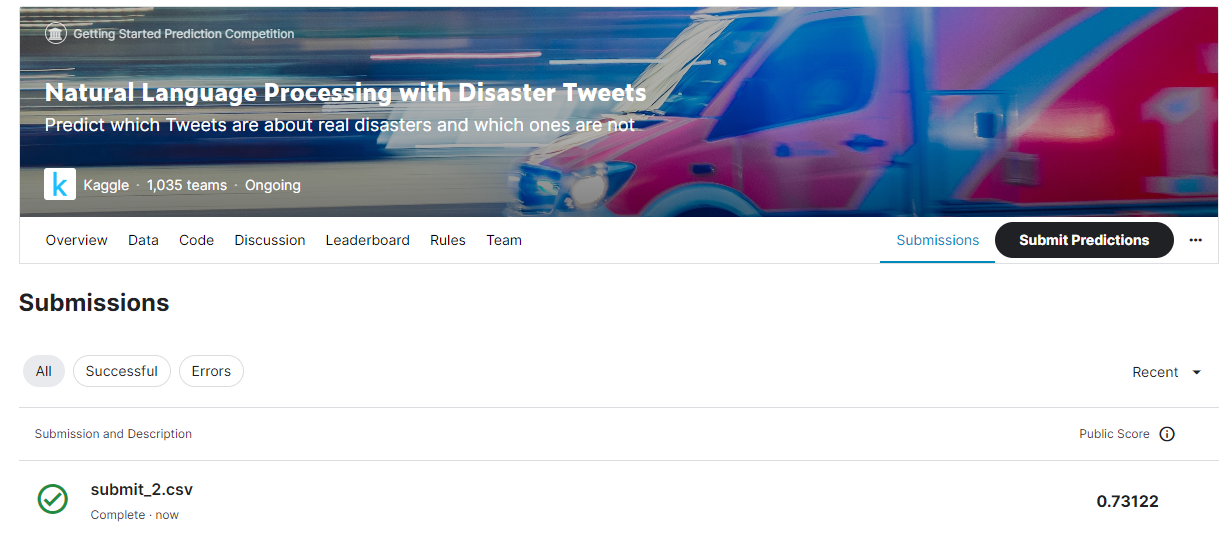

# Выводы


Можно улучшить точность используя уже натренерованные эмбеденнги, изменить модель, не удалять признаки и поработать с ними